# <center>Predictive Modeling of Cryptocurrency Prices Using ARIMA</center>

## Introduction

The cryptocurrency markets are renowned for their dynamic and unpredictable nature, providing a complex landscape for traders, investors, and analysts. This project seeks to employ advanced predictive modeling techniques to anticipate future movements in cryptocurrency prices.

## Business Problem

The ever-changing dynamics of cryptocurrency markets present a challenge for traders and investors striving to make well-informed decisions. This project addresses the demand for a predictive model adept at navigating the intricacies of cryptocurrency price movements, thereby assisting in strategic decision-making.

## Assumptions

- We assume that historical price trends in cryptocurrencies possess a certain degree of predictive capability.
- Recognizing the inherent volatility of cryptocurrency markets, we acknowledge the difficulty in achieving consistently high prediction accuracy.
- Unforeseen events or news impacting cryptocurrency values rapidly may not be explicitly incorporated into this model.


## 1. Importing Necessary libraries

In [1]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
from math import sqrt
from pandas import DataFrame
from pandas import read_csv
from pandas import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

C:\Users\KIIT\AppData\Local\Temp\ipykernel_17992\1176809914.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## 2. Importing Bitcoin Historical Data

In [2]:
# Importing the bitcoin csv
data = pd.read_csv("btc_6h.csv")
data.head()

,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13155.38,13558.99,2421.241182
1,2018-01-01 11:30:00,13539.00,13818.55,13001.13,13220.56,1876.934392
2,2018-01-01 17:30:00,13220.56,13330.00,12750.00,13022.00,2427.898747
3,2018-01-01 23:30:00,13007.87,13599.70,12940.00,13380.00,1883.841523
4,2018-01-02 05:30:00,13382.16,13850.00,12890.02,13166.95,3957.954564


In [3]:
# Checking the shape of the dataframe
data.shape

(5959, 6)

## 3. Feature Exploration
In this section, we compute crucial technical indicators to evaluate the daily price dynamics of the financial instrument within the dataset:
- These technical indicators serve as pivotal instruments for traders and analysts in gauging the current state of the market, identifying potential trend shifts, and recognizing overbought/oversold conditions.
- Whether used individually or in conjunction with other indicators, they empower stakeholders to make more informed trading and investment decisions. It's important to note that, while these indicators offer valuable insights, their utilization should be complemented with other forms of analysis, robust risk management practices, and a well-defined trading strategy.

In [4]:
# Exploring the close column seperately
close_data = data['close']
close_data
close_df = pd.DataFrame(close_data,columns =['close'])
close_df.head()

,close
0,13558.99
1,13220.56
2,13022.00
3,13380.00
4,13166.95


In [5]:
# Shifting the close column
data['next'] = data['close'].shift(-1)

In [6]:
# Calculate daily price change and percentage change
data['PriceChange'] = data['close'].diff()
data['PriceChangePercentage'] = data['close'].pct_change() * 100

# Calculate daily returns
data['Daily_Return'] = data['close'].pct_change() * 100

### 3.1 Simple Moving Average (SMA) :
The Simple Moving Average (SMA) serves as a trend-following indicator by computing the average of closing prices within a defined timeframe. This aids in smoothing out price data, facilitating the identification of trends. Crossovers in SMA indicate potential shifts in trends, either signaling reversals or continuations.

**Formula:**
The SMA is calculated as follows:
 - SMA = (Sum of prices over n periods) / n

In [7]:
# Calculate moving averages
data['SMA'] = data['close'].rolling(window=14).mean()

### 3.2 Exponential Moving Average (EMA) :
EMA is a responsive moving average that gives more weight to recent prices, making it effective for capturing short-term price changes and trends.

**Importance:**
- **Responsiveness:** EMA reacts quickly to price movements, making it useful for identifying forming or changing trends.

**Formula**:
 - EMA = (Current Price * (2 / (1 + n)) + Previous EMA * (1 - 2 / (1 + n))



In [8]:
# Calculate the Short and Long Exponential Moving Averages (EMA)
data['ShortEMA'] = data['close'].ewm(span=7, adjust=False).mean()
data['LongEMA'] = data['close'].ewm(span=30, adjust=False).mean()

### 3.3 MACD (Moving Average Convergence Divergence) :
MACD is a trend-following momentum indicator that consists of the MACD line (the difference between two EMAs) and the signal line (a 9-day EMA of the MACD line). It helps identify potential changes in trend direction and momentum in financial instruments.

**Importance:**
- **Bullish Signal:** MACD line crossing above the signal line indicates potential upward momentum.
- **Bearish Signal:** MACD line crossing below the signal line suggests potential downward momentum.

**Formula**
 - MACD = Short-term EMA - Long-term EMA

In [9]:
# Calculate the Moving Average Convergence Divergence (MACD)
data['MACD'] = data['ShortEMA'] - data['LongEMA']

### 3.4 Relative Strength Index (RSI) :
RSI is a momentum oscillator that measures the speed and change of price movements, ranging from 0 to 100. Values above 70 suggest overbought conditions (potential sell signals), while values below 30 indicate oversold conditions (potential buy signals).

- **Momentum Assessment:** RSI helps assess the overextension of an asset in one direction, providing insights into potential reversals or corrections.

**Formula**:
 - RSI = 100 - (100 / (1 + RS))
 - RS (Relative Strength) = Average Gain / Average Loss
 - Average Gain = (Sum of gains over n periods) / n
 - Average Loss = (Sum of losses over n periods) / n

In [10]:
# Calculate the Relative Strength Index (RSI)
rsi_window = 14
delta = data['close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=rsi_window).mean()
avg_loss = loss.rolling(window=rsi_window).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

### 3.5 Calculate True Range (TR) :
True Range (TR) is a measure of price volatility that considers the greatest of the following three ranges for each period: High minus Low (HL), absolute value of High minus the previous day's Close (HC), and absolute value of Low minus the previous day's Close (LC).

**Calculations**:
- **HL (High-Low):** The absolute difference between High and Low prices.
- **HC (High-Close):** Absolute value of the difference between High and the previous day's Close.
- **LC (Low-Close):** Absolute value of the difference between Low and the previous day's Close.
- **TR (True Range):** Maximum value among HL, HC, and LC for each period.

In [11]:
# Calculate True Range (TR)
data['HL'] = data['high'] - data['low']
data['HC'] = abs(data['high'] - data['close'].shift(1))
data['LC'] = abs(data['low'] - data['close'].shift(1))
data['TR'] = data[['HL', 'HC', 'LC']].max(axis=1)

## 4. Exploratory Data Analysis (EDA)

### 4.1 Descriptive Data Analysis

#### 4.1.1 Exploring the Dataframe's head and tails

In [12]:
data.head()

,datetime,open,high,low,close,volume,next,PriceChange,PriceChangePercentage,Daily_Return,SMA,ShortEMA,LongEMA,MACD,RSI,HL,HC,LC,TR
0,2018-01-01 05:30:00,13715.65,13715.65,13155.38,13558.99,2421.241182,13220.56,NaN,NaN,NaN,NaN,13558.990000,13558.990000,0.000000,NaN,560.27,NaN,NaN,560.27
1,2018-01-01 11:30:00,13539.00,13818.55,13001.13,13220.56,1876.934392,13022.00,-338.43,-2.495982,-2.495982,NaN,13474.382500,13537.155806,-62.773306,NaN,817.42,259.56,557.86,817.42
2,2018-01-01 17:30:00,13220.56,13330.00,12750.00,13022.00,2427.898747,13380.00,-198.56,-1.501903,-1.501903,NaN,13361.286875,13503.919948,-142.633073,NaN,580.00,109.44,470.56,580.00
3,2018-01-01 23:30:00,13007.87,13599.70,12940.00,13380.00,1883.841523,13166.95,358.00,2.749194,2.749194,NaN,13365.965156,13495.925113,-129.959956,NaN,659.70,577.70,82.00,659.70
4,2018-01-02 05:30:00,13382.16,13850.00,12890.02,13166.95,3957.954564,13490.00,-213.05,-1.592302,-1.592302,NaN,13316.211367,13474.700912,-158.489545,NaN,959.98,470.00,489.98,959.98


In [13]:
data.tail()

,datetime,open,high,low,close,volume,next,PriceChange,PriceChangePercentage,Daily_Return,SMA,ShortEMA,LongEMA,MACD,RSI,HL,HC,LC,TR
5954,2022-01-30 05:30:00,38166.83,38300.00,37737.49,38139.39,4656.39776,38110.02,-27.45,-0.071921,-0.071921,37175.800714,37731.778646,37506.766615,225.012032,50.713267,562.51,133.16,429.35,562.51
5955,2022-01-30 11:30:00,38139.38,38359.26,37795.00,38110.02,6113.43561,37991.00,-29.37,-0.077007,-0.077007,37268.706429,37826.338985,37545.686188,280.652797,61.405552,564.26,219.87,344.39,564.26
5956,2022-01-30 17:30:00,38110.03,38153.82,37712.05,37991.00,4075.22188,37881.76,-119.02,-0.312306,-0.312306,37412.821429,37867.504238,37574.416111,293.088127,70.236689,441.77,43.80,397.97,441.77
5957,2022-01-30 23:30:00,37991.00,38230.00,37351.63,37881.76,6585.61002,37001.65,-109.24,-0.287542,-0.287542,37498.662857,37871.068179,37594.244749,276.823430,63.694937,878.37,239.00,639.37,878.37
5958,2022-01-31 05:30:00,37881.75,37951.07,36632.61,37001.65,8627.98538,NaN,-880.11,-2.323308,-2.323308,37550.064286,37653.713634,37556.012830,97.700804,57.388538,1318.46,69.31,1249.15,1318.46


#### 4.1.2 Concise summary of Dataframe

In [14]:
# Display concise summary of DataFrame information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5959 entries, 0 to 5958
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   datetime               5959 non-null   object 
 1   open                   5959 non-null   float64
 2   high                   5959 non-null   float64
 3   low                    5959 non-null   float64
 4   close                  5959 non-null   float64
 5   volume                 5959 non-null   float64
 6   next                   5958 non-null   float64
 7   PriceChange            5958 non-null   float64
 8   PriceChangePercentage  5958 non-null   float64
 9   Daily_Return           5958 non-null   float64
 10  SMA                    5946 non-null   float64
 11  ShortEMA               5959 non-null   float64
 12  LongEMA                5959 non-null   float64
 13  MACD                   5959 non-null   float64
 14  RSI                    5946 non-null   float64
 15  HL  

#### 4.1.3 Descriptive Statistics of the model

In [15]:
# Generate descriptive statistics of the DataFrame
data.describe()

,open,high,low,close,volume,next,PriceChange,PriceChangePercentage,Daily_Return,SMA,ShortEMA,LongEMA,MACD,RSI,HL,HC,LC,TR
count,5959.000000,5959.000000,5959.000000,5959.000000,5959.000000,5958.000000,5958.000000,5958.000000,5958.000000,5946.000000,5959.000000,5959.000000,5959.000000,5946.000000,5959.000000,5958.000000,5958.000000,5959.000000
mean,18797.185464,19070.762218,18493.878941,18801.139626,13616.979970,18802.019476,3.934653,0.036863,0.036863,18786.039954,18789.009374,18742.747810,46.261564,51.623073,576.883277,273.579461,303.312734,576.886342
std,17861.091261,18123.743781,17567.672529,17862.540801,10387.521301,17863.910889,523.774616,1.994756,1.994756,17853.156008,17845.196014,17785.874384,960.118964,18.165009,778.921655,445.229612,570.876063,778.921273
min,3185.940000,3213.000000,3156.260000,3185.940000,750.084552,3185.940000,-6063.020000,-21.499491,-21.499491,3241.053571,3233.292480,3342.032075,-5842.431588,7.081317,10.070000,0.000000,0.000000,10.070000
25%,7123.955000,7218.670000,7033.475000,7123.250000,7233.905716,7122.305000,-80.722500,-0.690877,-0.690877,7119.630536,7127.073128,7133.105469,-190.204983,38.146913,115.000000,35.760000,37.507500,115.000000
50%,9536.330000,9632.180000,9410.000000,9536.880000,10873.472133,9535.930000,3.360000,0.040756,0.040756,9518.032500,9531.723871,9476.889743,13.988332,51.460046,244.900000,100.450000,101.880000,244.900000
75%,32745.415000,33279.390000,31968.220000,32761.855000,16658.723685,32767.417500,90.290000,0.789504,0.789504,32981.870357,32732.465090,33289.518451,254.922268,64.966544,787.215000,302.780000,320.162500,787.215000
max,68635.120000,69000.000000,67300.000000,68633.690000,162319.716490,68633.690000,4045.000000,12.264890,12.264890,66483.813571,67039.963306,64619.756076,4727.627593,96.775106,11858.800000,5494.920000,11600.750000,11858.800000


#### 4.1.4 Data Cleaning

In [16]:
# Count the number of missing values in each column
data.isnull().sum()

datetime                  0
open                      0
high                      0
low                       0
close                     0
volume                    0
next                      1
PriceChange               1
PriceChangePercentage     1
Daily_Return              1
SMA                      13
ShortEMA                  0
LongEMA                   0
MACD                      0
RSI                      13
HL                        0
HC                        1
LC                        1
TR                        0
dtype: int64

In [17]:
# Drop rows with missing values from the DataFrame
data = data.dropna()

In [18]:
# Display the shape of the DataFrame (number of rows and columns)
data.shape

(5945, 19)

In [19]:
# Displaying the types of the columns
data.dtypes

datetime                  object
open                     float64
high                     float64
low                      float64
close                    float64
volume                   float64
next                     float64
PriceChange              float64
PriceChangePercentage    float64
Daily_Return             float64
SMA                      float64
ShortEMA                 float64
LongEMA                  float64
MACD                     float64
RSI                      float64
HL                       float64
HC                       float64
LC                       float64
TR                       float64
dtype: object

### 4.2 Graphical Data Analysis

#### 4.2.1 Volume Visualisation


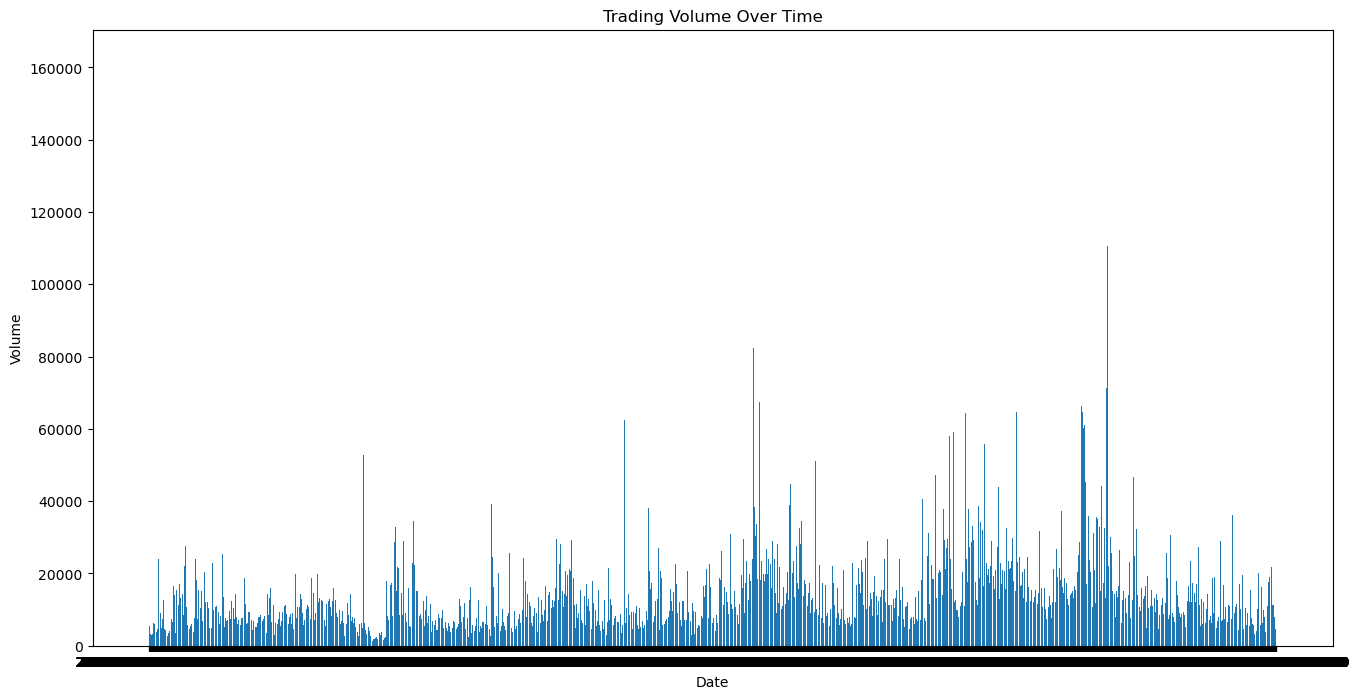

In [20]:
# Calculate basic statistics for volume
volume_stats = data['volume'].describe()

# Visualize volume using a bar chart
plt.figure(figsize=(16,8))
plt.bar(data['datetime'], data['volume'])
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Trading Volume Over Time')
plt.show()

#### 4.2.2 Plotting the Closing price

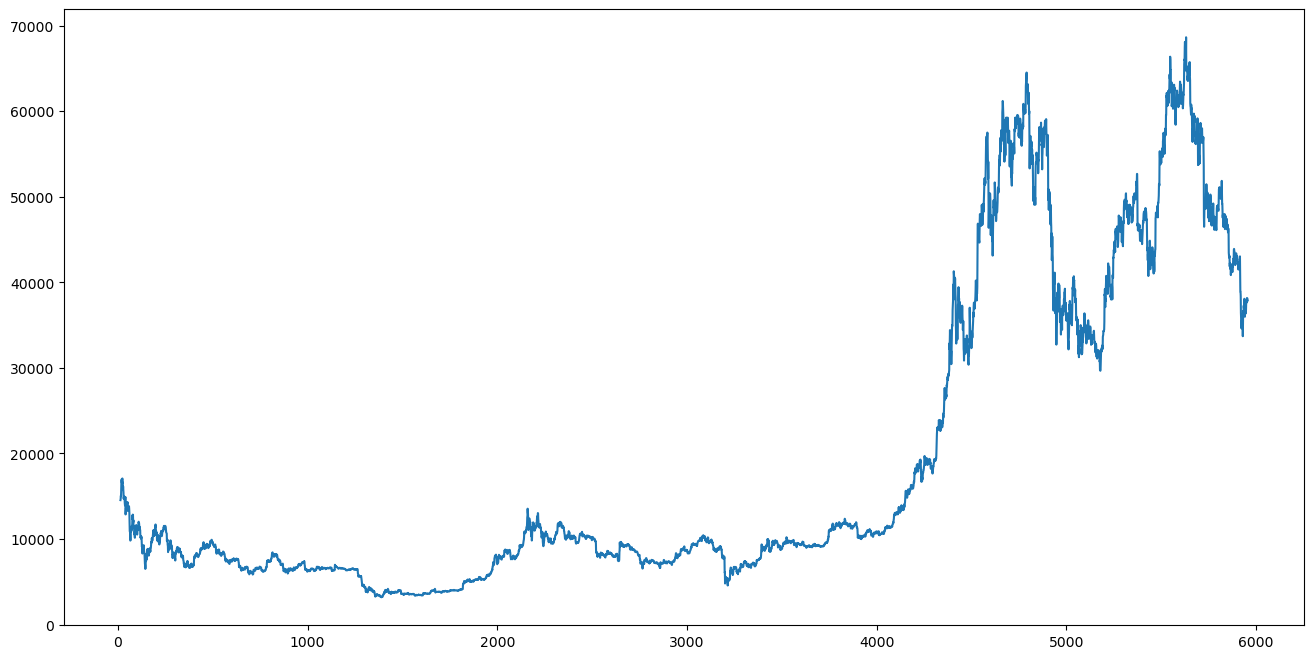

In [21]:
# Visualize Closing price using a line chart
plt.figure(figsize=(16,8))
plt.plot(data['close'])
plt.show()

#### 4.2.3 Plotting the Target Variable Distribution

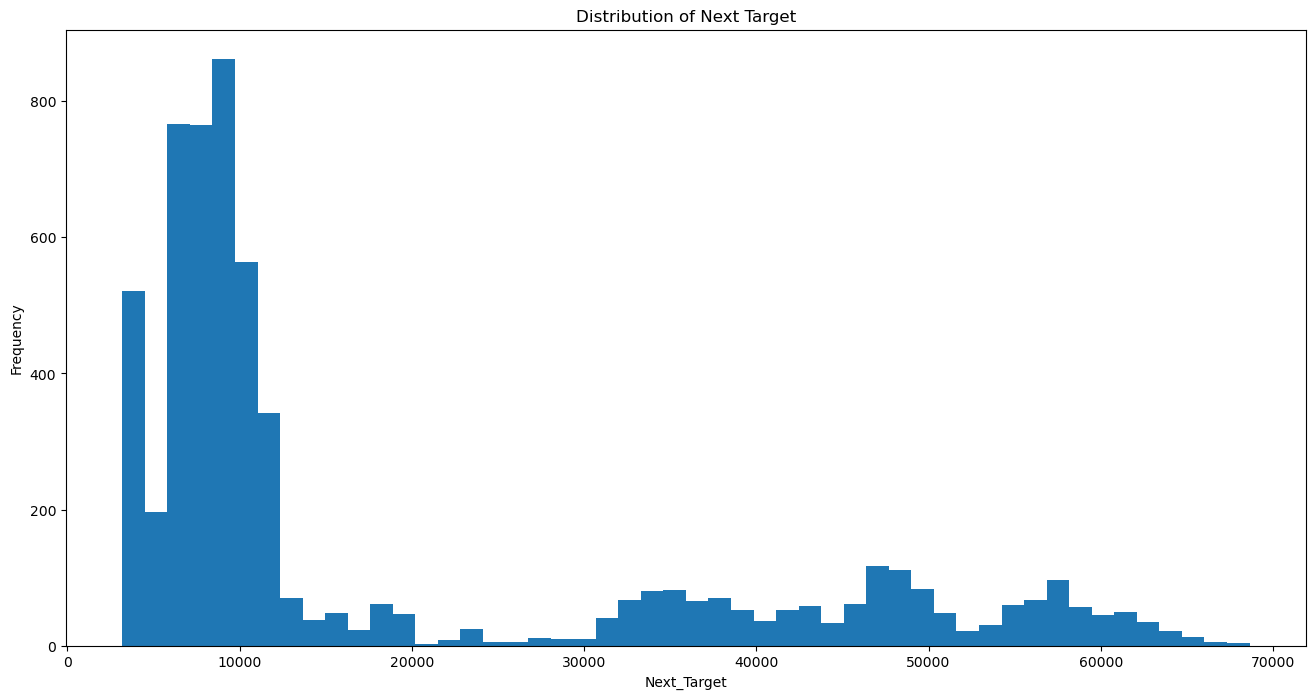

In [22]:
# Analyze the distribution of the target variable (TargetNextClose)
close_next_stats = data[data['next'] != 0]['next'].describe()

# Visualize the target variable
plt.figure(figsize=(16,8))
plt.hist(data['next'], bins=50)
plt.xlabel('Next_Target')
plt.ylabel('Frequency')
plt.title('Distribution of Next Target')
plt.show()

#### 4.2.4 Technical Indicators Visualisation

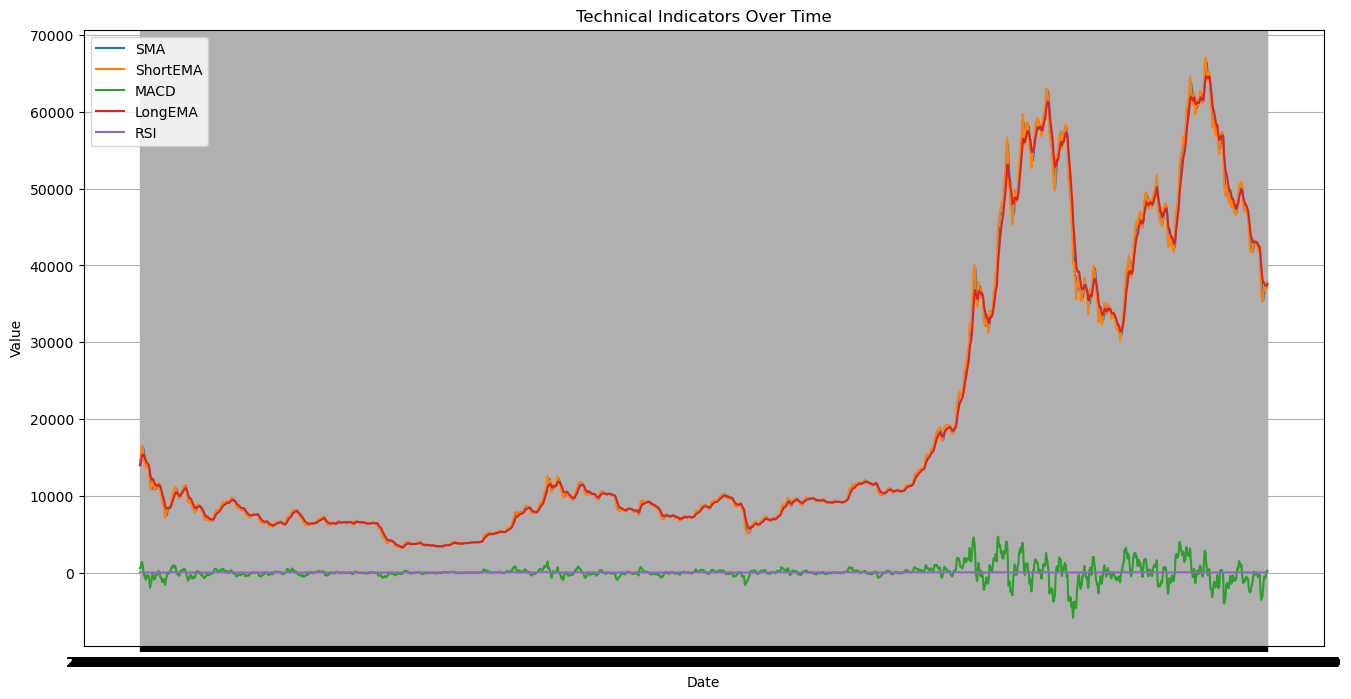

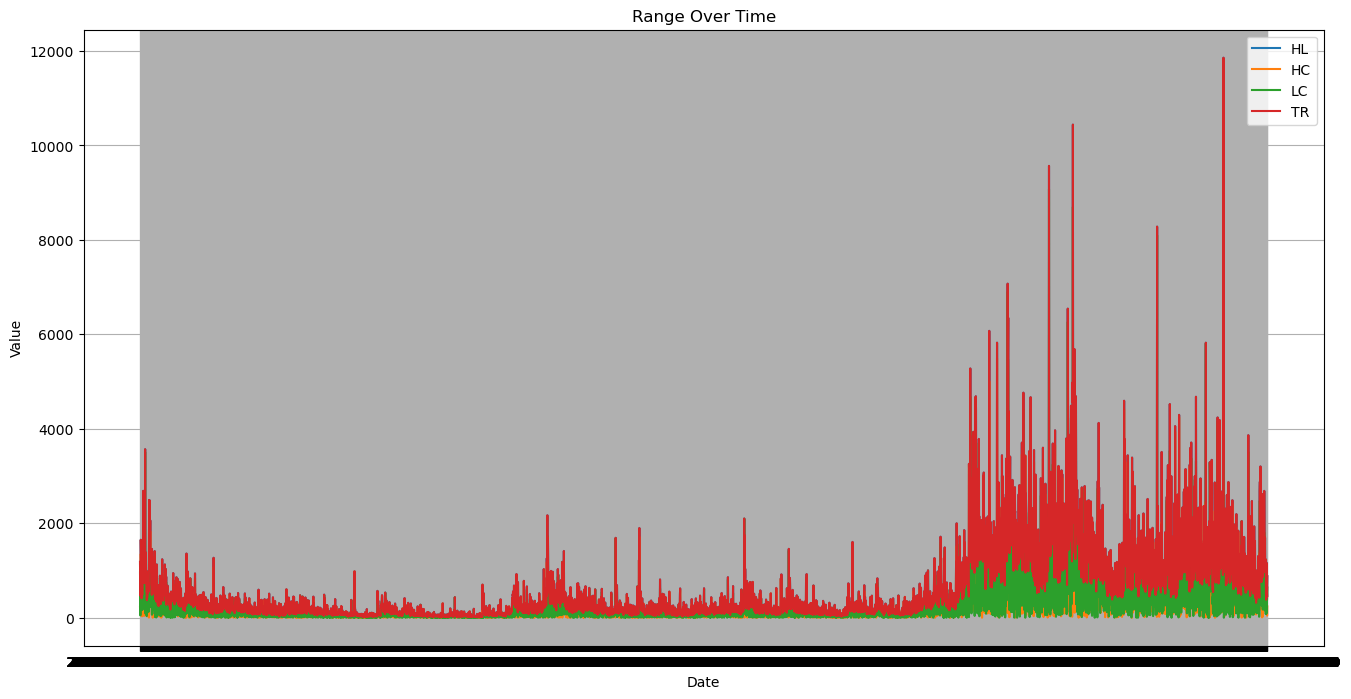

In [23]:
# Technical Indicator Columns
technical_indicators = ['SMA','ShortEMA','MACD','LongEMA','RSI']

# Calculate basic statistics for technical indicator columns
technical_stats = data[technical_indicators].describe()

# Visualize technical indicators
plt.figure(figsize=(16, 8))
for col in technical_indicators:
    plt.plot(data['datetime'], data[col], label=col)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Technical Indicators Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Range Columns
columns_part = ['HL', 'HC', 'LC', 'TR']

# Calculate basic statistics for the first set of intraday range columns
stats_part = data[columns_part].describe()

# Visualize the first set of intraday range columns
plt.figure(figsize=(16, 8))
for col in columns_part:
    plt.plot(data['datetime'], data[col], label=col)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Range Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Drop redundant columns from the DataFrame
data = data.drop(columns=['datetime', 'ShortEMA', 'LongEMA'])

#### 4.2.5 Correlation Heatmap

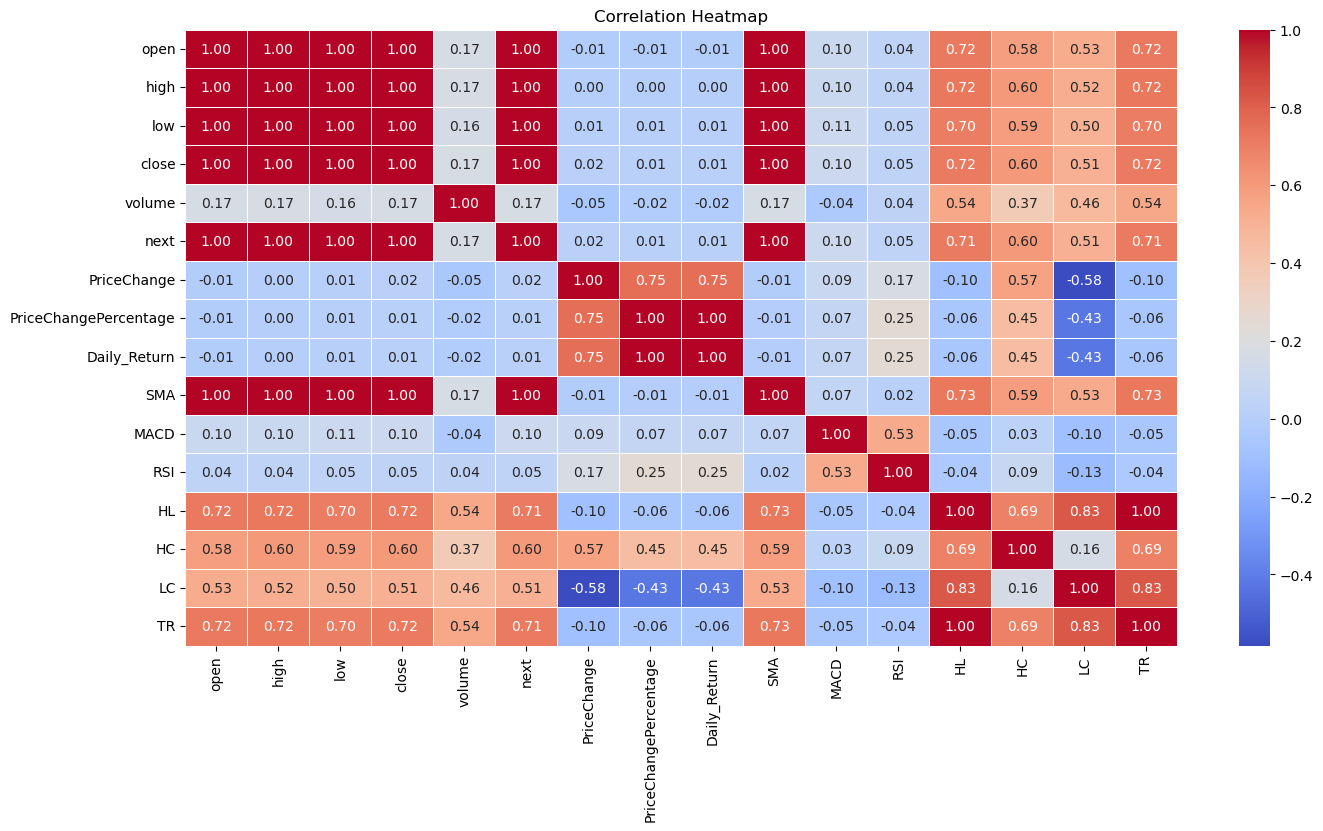

In [25]:
# Create a correlation matrix
corr = data.corr()

# Plot the Heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

## 5. Split Data into Train, Validation, and Test Sets

In [26]:
# Split into train and test sets
X = data['next'].values
size = int(len(X) * 0.8)

# Split first 80% for training
X_train_3 = X[:size]

# Split next 10% (80-90%) for validation
validation_size = int(size + 0.1 * len(X))
X_val_3 = X[size:validation_size]

# Split last 10% (90-100%) for testing
X_test_3 = X[validation_size:]

# Initialize a list to store prediction history
history = [x for x in X_train_3]

## 6. Auto Regressive Integrated Moving Average (ARIMA) Model

### 6.1 Reasons for choosing ARIMA model :
1. **Time Series Fit:**
   - ARIMA suits Bitcoin due to its time-dependent structure.

2. **Stationary Adaptation:**
   - ARIMA accommodates Bitcoin's non-stationary nature through differencing.

3. **Limited External Influence:**
   - ARIMA is effective as Bitcoin prices are less affected by external factors.

4. **Simplicity and Transparency:**
   - ARIMA's simplicity aids interpretability in the unpredictable Bitcoin market.

### 6.2 Walk-forward validation using ARIMA model :
In the walk-forward prediction approach, the model undergoes training on historical data up to a specific point. Subsequently, predictions are made step by step, where each new prediction updates the model.

- After experimenting with various p, q, d values (3, 2, 0; 1, 4, 8), we determined that the optimal combination is 5, 1, 0.
- The ARIMA(5,1,0) model is then trained using historical data ('history') up to the current step in the validation set. The model predicts the next value, and this process repeats for each step in the validation set.
- This walk-forward validation aids in evaluating the model's performance on unseen data, continually refining predictions as new information becomes available.

In [27]:
# Walk-forward validation using ARIMA model for validation data

val_pred = list()
for t in range(len(X_val_3)):

    # Fit ARIMA model on the training data
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()

    # Forecast the next value
    output = model_fit.forecast()
    yhat = output[0]

    # Append the predicted value to the list of predictions
    val_pred.append(yhat)

    # Update the history with the observed value
    obs = X_val_3[t]
    history.append(obs)

    # Print the predicted and expected values for each iteration
    print('Predicted=%f, Expected=%f' % (yhat, obs))

Predicted=58037.223224, Expected=57947.670000
Predicted=57979.899763, Expected=58527.190000
Predicted=58479.900220, Expected=58405.080000
Predicted=58369.118010, Expected=58142.540000
Predicted=58149.641634, Expected=60851.920000
Predicted=60868.899770, Expected=60575.940000
Predicted=60578.351887, Expected=60100.480000
Predicted=60163.398865, Expected=59769.130000
Predicted=59615.461749, Expected=59679.970000
Predicted=59649.574377, Expected=59721.840000
Predicted=59744.555567, Expected=59864.390000
Predicted=59888.683192, Expected=60002.430000
Predicted=60014.844091, Expected=60207.010000
Predicted=60212.609438, Expected=60241.500000
Predicted=60237.223723, Expected=59749.400000
Predicted=59735.510460, Expected=59860.000000
Predicted=59848.662624, Expected=60668.740000
Predicted=60669.745346, Expected=62942.210000
Predicted=63018.973689, Expected=63332.850000
Predicted=63361.358929, Expected=63575.000000
Predicted=63577.289689, Expected=64038.490000
Predicted=63928.538259, Expected=6

Predicted=32705.114697, Expected=34655.250000
Predicted=34654.396287, Expected=35292.600000
Predicted=35435.353684, Expected=37600.010000
Predicted=37920.317965, Expected=37669.770000
Predicted=37597.421074, Expected=38796.290000
Predicted=38712.801122, Expected=38356.500000
Predicted=38155.517081, Expected=36537.160000
Predicted=36457.896614, Expected=37951.980000
Predicted=37806.811232, Expected=38324.720000
Predicted=38353.369515, Expected=39229.280000
Predicted=39429.192963, Expected=39850.650000
Predicted=39780.328469, Expected=38965.660000
Predicted=38915.401846, Expected=39241.910000
Predicted=39134.648869, Expected=38136.540000
Predicted=38055.097313, Expected=39690.010000
Predicted=39741.705612, Expected=39028.990000
Predicted=39050.534375, Expected=38529.980000
Predicted=38623.427155, Expected=36996.450000
Predicted=36859.176020, Expected=35351.650000
Predicted=35344.494364, Expected=35976.170000
Predicted=35996.118687, Expected=35663.490000
Predicted=35827.649366, Expected=3

Predicted=34858.452150, Expected=34635.010000
Predicted=34607.267163, Expected=33862.120000
Predicted=33806.529283, Expected=32884.560000
Predicted=32860.524139, Expected=32696.440000
Predicted=32695.198958, Expected=32863.830000
Predicted=32938.510463, Expected=32875.710000
Predicted=32973.928967, Expected=32996.180000
Predicted=33019.805602, Expected=32774.990000
Predicted=32766.414332, Expected=33481.070000
Predicted=33468.491519, Expected=33815.810000
Predicted=33827.397582, Expected=33649.030000
Predicted=33667.619091, Expected=33793.940000
Predicted=33726.536992, Expected=33397.270000
Predicted=33369.173656, Expected=33502.870000
Predicted=33500.483861, Expected=33590.530000
Predicted=33587.562894, Expected=33814.840000
Predicted=33847.820918, Expected=33892.810000
Predicted=33892.615489, Expected=34258.990000
Predicted=34248.783156, Expected=34330.250000
Predicted=34319.465502, Expected=33530.000000
Predicted=33520.700282, Expected=33112.120000
Predicted=33057.608672, Expected=3

Predicted=48826.049685, Expected=48501.870000
Predicted=48356.647968, Expected=49647.880000
Predicted=49591.098489, Expected=48821.870000
Predicted=48886.173061, Expected=49129.760000
Predicted=49110.954941, Expected=49132.040000
Predicted=49081.609880, Expected=48677.280000
Predicted=48721.069546, Expected=49239.220000
Predicted=49210.862309, Expected=50220.940000
Predicted=50234.713983, Expected=50394.850000
Predicted=50432.878232, Expected=49413.670000
Predicted=49365.007501, Expected=49488.850000
Predicted=49393.326353, Expected=49557.770000
Predicted=49561.773756, Expected=49429.990000
Predicted=49496.024566, Expected=48001.010000
Predicted=48007.705037, Expected=47674.010000
Predicted=47645.348933, Expected=48520.020000
Predicted=48550.394215, Expected=47570.010000
Predicted=47695.410071, Expected=48830.000000
Predicted=48817.796827, Expected=48973.320000
Predicted=48962.667563, Expected=47042.360000
Predicted=47092.447808, Expected=46835.890000
Predicted=46720.627070, Expected=4

## 7. Model Evaluation Metrics

In model evaluation, various metrics are considered to assess the performance of the model. The following metrics are commonly used:

- **Mean Squared Error (MSE):**
  Formula: MSE = (1/n) * Σ(yᵢ - ȳ)²

- **Root Mean Squared Error (RMSE):**
  Formula: RMSE = √MSE

- **R2 Score:**
  Formula: R² = 1 - Σ(yᵢ - ȳ)² / Σ(yᵢ - ȳ̅)²

- **Mean Absolute Error (MAE):**
  Formula: MAE = (1/n) * Σ|yᵢ - ȳ|

- **Mean Absolute Percentage Error (MAPE):**
  Formula: MAPE = (1/n) * Σ(|yᵢ - ȳ| / |yᵢ|) * 100

### 7.1 Model Evaluation on Validation Set

In [28]:
# Convert validation and predictions to DataFrames for plotting
val_df = DataFrame(X_val_3, index=data['next'].index[size:validation_size], columns=['Actual'])
val_pred_df = DataFrame(val_pred, index=data['next'].index[size:validation_size], columns=['Predicted'])

# Evaluate forecasts for validation data
mse_val = mean_squared_error(val_df, val_pred_df)
rmse_val = np.sqrt(mse_val)

# Calculate R-squared (R^2) score for validation data
r2_val = r2_score(val_df, val_pred_df)

# Calculate Mean Absolute Error (MAE) for validation data
mae_val = mean_absolute_error(val_df, val_pred_df)

# Calculate Mean Absolute Percentage Error (MAPE) for validation data
mape_val = np.mean(np.abs((np.array(val_df) - np.array(val_pred_df)) / np.array(val_df))) * 100

# Print results for validation data
print(f'Mean Squared Error (MSE) for Validation Data: {mse_val:.3f}')
print(f'Root Mean Squared Error (RMSE) for Validation Data: {rmse_val:.3f}')
print(f'R-squared (R^2) Score for Validation Data: {r2_val:.3f}')
print(f'Mean Absolute Error (MAE) for Validation Data: {mae_val:.3f}')
print(f'Mean Absolute Percentage Error (MAPE) for Validation Data: {mape_val:.3f}%')

Mean Squared Error (MSE) for Validation Data: 931802.191
Root Mean Squared Error (RMSE) for Validation Data: 965.299
R-squared (R^2) Score for Validation Data: 0.989
Mean Absolute Error (MAE) for Validation Data: 693.084
Mean Absolute Percentage Error (MAPE) for Validation Data: 1.642%


### 7.2 Plotting the Validation predictions

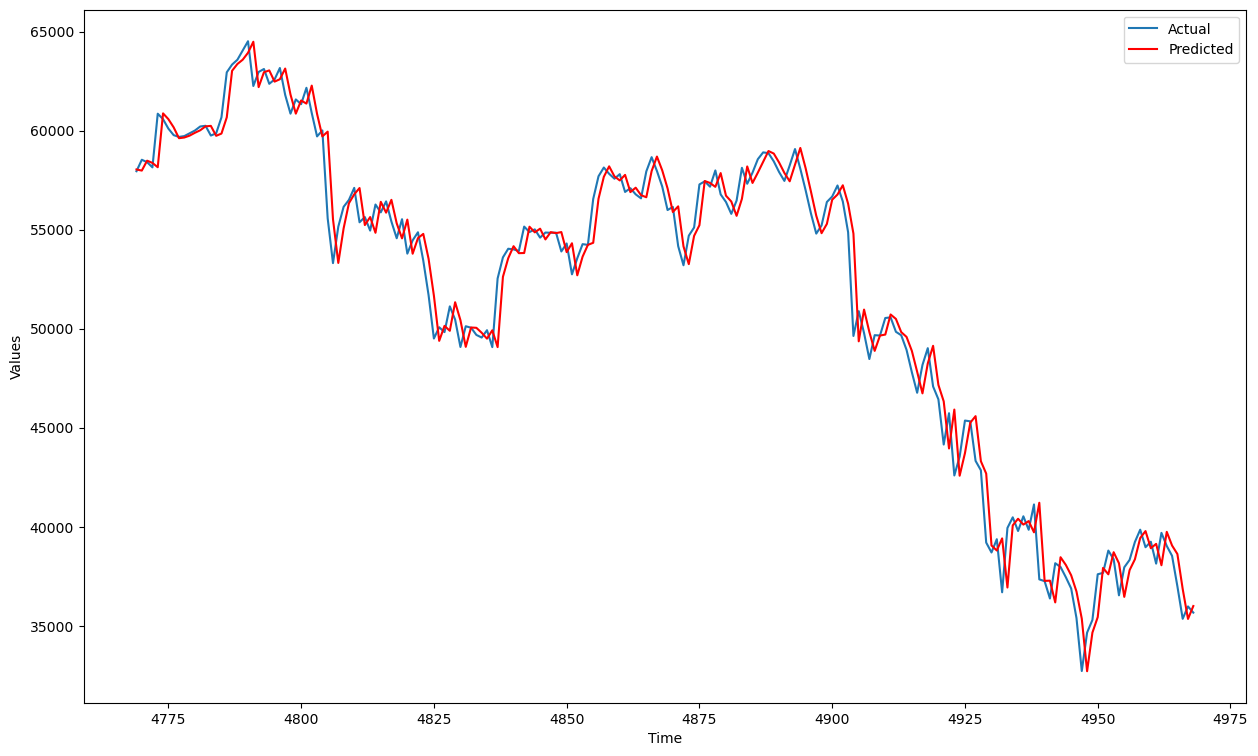

In [29]:
# Set the range you want to zoom in on
start_index = 0
end_index = 200

# Extract data for the specified range
actual_values = val_df['Actual'].iloc[start_index:end_index]
predicted_values = val_pred_df['Predicted'].iloc[start_index:end_index]
time_index = val_df.index[start_index:end_index]

# Set the plot size
plt.figure(figsize=(15, 9))

# Plot actual values
plt.plot(time_index, actual_values, label='Actual')

# Plot predicted values in red
plt.plot(time_index, predicted_values, color='red', label='Predicted')

# Add labels to the axes
plt.xlabel('Time')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show the plot
plt.show()

### 7.3 Model predictions on Test data

In [30]:
test_pred = list()
for t in range(len(X_test_3)):
    # Fit ARIMA model on the training data
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()

    # Forecast the next value
    output = model_fit.forecast()
    yhat = output[0]

    # Append the predicted value to the list of predictions
    test_pred.append(yhat)

    # Update the history with the observed value
    obs = X_test_3[t]
    history.append(obs)

    # Print the predicted and expected values for each iteration
    print('Predicted=%f, Expected=%f' % (yhat, obs))

Predicted=49893.899890, Expected=49954.830000
Predicted=49968.952121, Expected=49915.640000
Predicted=49907.774701, Expected=49688.800000
Predicted=49712.176881, Expected=50198.780000
Predicted=50192.787266, Expected=50299.690000
Predicted=50312.751904, Expected=51756.880000
Predicted=51755.898682, Expected=51759.990000
Predicted=51747.633458, Expected=51400.670000
Predicted=51365.177490, Expected=51672.980000
Predicted=51564.011872, Expected=52663.900000
Predicted=52654.125709, Expected=52665.010000
Predicted=52699.105593, Expected=50941.480000
Predicted=50919.666237, Expected=46606.440000
Predicted=46513.549186, Expected=46863.730000
Predicted=46837.839383, Expected=46074.840000
Predicted=46285.357719, Expected=46394.090000
Predicted=46684.889720, Expected=46200.190000
Predicted=46237.186664, Expected=46048.310000
Predicted=46089.387310, Expected=46304.440000
Predicted=46289.796476, Expected=46293.150000
Predicted=46311.088223, Expected=46766.320000
Predicted=46771.525714, Expected=4

Predicted=62546.815465, Expected=62128.390000
Predicted=62089.935320, Expected=63411.270000
Predicted=63377.260698, Expected=64280.590000
Predicted=64278.810320, Expected=63779.410000
Predicted=63788.385557, Expected=63791.100000
Predicted=63698.268521, Expected=66363.020000
Predicted=66316.414957, Expected=66001.410000
Predicted=66059.245179, Expected=64825.710000
Predicted=64786.528639, Expected=64827.900000
Predicted=64682.289686, Expected=62487.000000
Predicted=62509.747605, Expected=62193.150000
Predicted=62232.227421, Expected=63013.040000
Predicted=63050.365983, Expected=63376.800000
Predicted=63527.247400, Expected=60576.030000
Predicted=60604.630502, Expected=60688.220000
Predicted=60613.575467, Expected=60990.000000
Predicted=61003.380125, Expected=61552.230000
Predicted=61697.823923, Expected=61239.010000
Predicted=61255.852847, Expected=61286.750000
Predicted=61258.922988, Expected=60900.000000
Predicted=60874.090527, Expected=60281.000000
Predicted=60289.192235, Expected=6

Predicted=56512.952044, Expected=56725.860000
Predicted=56758.923640, Expected=56959.770000
Predicted=56953.657974, Expected=54982.310000
Predicted=54995.431387, Expected=53601.050000
Predicted=53574.013921, Expected=47538.030000
Predicted=47502.012631, Expected=46489.670000
Predicted=46500.234122, Expected=48241.050000
Predicted=48397.029789, Expected=49152.470000
Predicted=49575.433298, Expected=49424.000000
Predicted=49544.725493, Expected=49242.580000
Predicted=49137.429327, Expected=49262.210000
Predicted=49184.819616, Expected=49396.330000
Predicted=49374.300077, Expected=48678.540000
Predicted=48683.623226, Expected=48577.780000
Predicted=48569.213209, Expected=48961.230000
Predicted=48962.773346, Expected=50441.920000
Predicted=50497.960984, Expected=50872.920000
Predicted=50898.459071, Expected=51456.200000
Predicted=51423.865748, Expected=50999.970000
Predicted=50903.661072, Expected=50588.950000
Predicted=50532.525745, Expected=50404.900000
Predicted=50365.504134, Expected=4

Predicted=43085.920673, Expected=43071.660000
Predicted=43083.947545, Expected=42664.680000
Predicted=42662.879791, Expected=42671.310000
Predicted=42662.232887, Expected=42110.830000
Predicted=42111.368518, Expected=42201.620000
Predicted=42221.490265, Expected=42097.250000
Predicted=42109.243796, Expected=41854.140000
Predicted=41883.709957, Expected=41489.040000
Predicted=41489.476582, Expected=42352.120000
Predicted=42360.754897, Expected=41762.550000
Predicted=41786.222133, Expected=42033.000000
Predicted=42044.693078, Expected=42151.010000
Predicted=42115.467167, Expected=41660.010000
Predicted=41677.598519, Expected=41879.200000
Predicted=41867.927155, Expected=42129.440000
Predicted=42126.595831, Expected=43025.850000
Predicted=43055.861990, Expected=40680.910000
Predicted=40672.430275, Expected=38909.010000
Predicted=38856.784266, Expected=38898.180000
Predicted=38859.702547, Expected=38382.500000
Predicted=38522.438915, Expected=36445.310000
Predicted=36563.473436, Expected=3

In [31]:
# Convert test and predictions to DataFrames for plotting
test_df = DataFrame(X_test_3, index=data['next'].index[validation_size:], columns=['Actual'])
test_pred_df = DataFrame(test_pred, index=data['next'].index[validation_size:], columns=['Predicted'])

In [32]:
test_df.drop(test_df.tail(1).index, inplace=True)

In [33]:
test_pred_df.drop(test_pred_df.tail(1).index, inplace=True)

### 7.4 Model Evaluation on Test Set

In [34]:
# Evaluate forecasts for test data
mse_test = mean_squared_error(test_df, test_pred_df)
rmse_test = np.sqrt(mse_test)

# Calculate R-squared (R^2) score for test data
r2_test = r2_score(test_df, test_pred_df)

# Calculate Mean Absolute Error (MAE) for test data
mae_test = mean_absolute_error(test_df, test_pred_df)

# Calculate Mean Absolute Percentage Error (MAPE) for test data
mape_test = np.mean(np.abs((np.array(test_df) - np.array(test_pred_df)) / np.array(test_df))) * 100

# Print results for test data
print(f'Mean Squared Error (MSE) for Test Data: {mse_test:.3f}')
print(f'Root Mean Squared Error (RMSE) for Test Data: {rmse_test:.3f}')
print(f'R-squared (R^2) Score for Test Data: {r2_test:.3f}')
print(f'Mean Absolute Error (MAE) for Test Data: {mae_test:.3f}')
print(f'Mean Absolute Percentage Error (MAPE) for Test Data: {mape_test:.3f}%')

Mean Squared Error (MSE) for Test Data: 773706.610
Root Mean Squared Error (RMSE) for Test Data: 879.606
R-squared (R^2) Score for Test Data: 0.988
Mean Absolute Error (MAE) for Test Data: 598.667
Mean Absolute Percentage Error (MAPE) for Test Data: 1.189%


### 7.5 Plotting the Test predictions

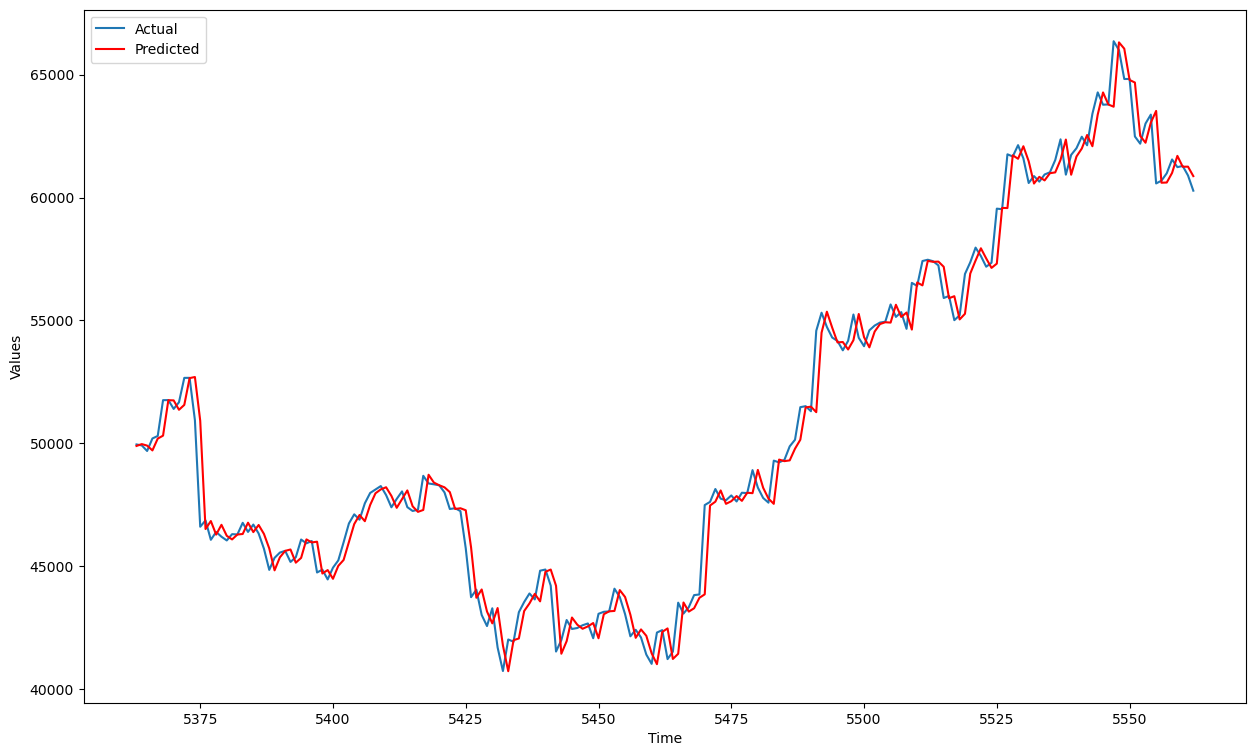

In [35]:
# Set the range you want to zoom in on
start_index = 0
end_index = 200

# Extract data for the specified range
actual_values_test = test_df['Actual'].iloc[start_index:end_index]
predicted_values_test = test_pred_df['Predicted'].iloc[start_index:end_index]
time_index_test = test_df.index[start_index:end_index]

# Set the plot size
plt.figure(figsize=(15, 9))

# Plot actual values
plt.plot(time_index_test, actual_values_test, label='Actual')

# Plot predicted values in red
plt.plot(time_index_test, predicted_values_test, color='red', label='Predicted')

# Add labels to the axes
plt.xlabel('Time')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show the plot
plt.show()

## 8. Out sample Testing

### 8.1 Importing the outsample data

In [36]:
# Importing the outsample data
out_sample_test_2023 = pd.read_csv('BTC-USD.csv')

In [37]:
outsample_test_data = list(out_sample_test_2023['Close'].values)
history_all = list(data['close'].values)

In [38]:
outsample_test_data

[38743.273438,
 36952.984375,
 37154.601563,
 41500.875,
 41441.164063,
 42412.433594,
 43840.285156,
 44118.445313,
 44338.796875,
 43565.113281,
 42407.9375,
 42244.46875,
 42197.515625,
 42586.917969,
 44575.203125,
 43961.859375,
 40538.011719,
 40030.976563,
 40122.15625,
 38431.378906,
 37075.28125,
 38286.027344,
 37296.570313,
 38332.609375,
 39214.21875,
 39105.148438,
 37709.785156,
 43193.234375,
 44354.636719,
 43924.117188,
 42451.789063,
 39137.605469,
 39400.585938,
 38419.984375,
 38062.039063,
 38737.269531,
 41982.925781,
 39437.460938,
 38794.972656,
 38904.011719,
 37849.664063,
 39666.753906,
 39338.785156,
 41143.929688,
 40951.378906,
 41801.15625,
 42190.652344,
 41247.824219,
 41077.996094,
 42358.808594,
 42892.957031,
 43960.933594,
 44348.730469,
 44500.828125,
 46820.492188,
 47128.003906,
 47465.730469,
 47062.664063,
 45538.675781,
 46281.644531,
 45868.949219,
 46453.566406,
 46622.675781,
 45555.992188,
 43206.738281,
 43503.847656,
 42287.664063,
 4278

### 8.2 Model predictions on Outsample data

In [39]:
# Model predictions on Outsample data
predictions = []
for t in range(len(outsample_test_data)):
    Model = ARIMA(history_all, order = (5,1,0))
    Model_fit = Model.fit()
    output = Model_fit.forecast(steps = 30)
    y_hat = output[0]
    predictions.append(y_hat)
    observation = outsample_test_data[t]
    history_all.append(observation)

    print('Predicted=%f, Expected=%f' % (y_hat, observation))


Predicted=37873.965061, Expected=38743.273438
Predicted=38750.948023, Expected=36952.984375
Predicted=36954.800742, Expected=37154.601563
Predicted=37149.265399, Expected=41500.875000
Predicted=41490.783805, Expected=41441.164063
Predicted=41515.827269, Expected=42412.433594
Predicted=42410.365298, Expected=43840.285156
Predicted=43615.392080, Expected=44118.445313
Predicted=44049.544676, Expected=44338.796875
Predicted=44288.829141, Expected=43565.113281
Predicted=43469.351467, Expected=42407.937500
Predicted=42359.266268, Expected=42244.468750
Predicted=42226.847925, Expected=42197.515625
Predicted=42237.282417, Expected=42586.917969
Predicted=42664.914656, Expected=44575.203125
Predicted=44620.019325, Expected=43961.859375
Predicted=43965.135492, Expected=40538.011719
Predicted=40485.017926, Expected=40030.976563
Predicted=39922.059537, Expected=40122.156250
Predicted=40138.813608, Expected=38431.378906
Predicted=38613.050743, Expected=37075.281250
Predicted=37153.966744, Expected=3

Predicted=23848.908507, Expected=23656.207031
Predicted=23577.000796, Expected=23336.896484
Predicted=23257.010586, Expected=23314.199219
Predicted=23297.072580, Expected=22978.117188
Predicted=22983.834327, Expected=22846.507813
Predicted=22863.997317, Expected=22630.957031
Predicted=22635.051024, Expected=23289.314453
Predicted=23306.472436, Expected=22961.279297
Predicted=22975.201463, Expected=23175.890625
Predicted=23192.475764, Expected=23809.486328
Predicted=23779.414653, Expected=23164.318359
Predicted=23171.943902, Expected=23947.642578
Predicted=23944.913866, Expected=23957.529297
Predicted=23919.786184, Expected=24402.818359
Predicted=24430.051577, Expected=24424.068359
Predicted=24397.549772, Expected=24319.333984
Predicted=24307.193376, Expected=24136.972656
Predicted=24113.211869, Expected=23883.291016
Predicted=23872.169019, Expected=23335.998047
Predicted=23338.040033, Expected=23212.738281
Predicted=23219.892940, Expected=20877.552734
Predicted=20886.337539, Expected=2

Predicted=22602.276664, Expected=23117.859375
Predicted=23120.141814, Expected=23032.777344
Predicted=23022.605342, Expected=23078.728516
Predicted=23093.595025, Expected=23031.089844
Predicted=23010.345822, Expected=23774.566406
Predicted=23772.165427, Expected=22840.138672
Predicted=22840.878492, Expected=23139.283203
Predicted=23141.581133, Expected=23723.769531
Predicted=23681.508843, Expected=23471.871094
Predicted=23512.292482, Expected=23449.322266
Predicted=23453.101052, Expected=23331.847656
Predicted=23293.484572, Expected=22955.666016
Predicted=22957.121622, Expected=22760.109375
Predicted=22762.978537, Expected=23264.291016
Predicted=23268.371393, Expected=22939.398438
Predicted=22961.984865, Expected=21819.039063
Predicted=21836.232226, Expected=21651.183594
Predicted=21620.653677, Expected=21870.875000
Predicted=21870.979545, Expected=21788.203125
Predicted=21852.821039, Expected=21808.101563
Predicted=21838.456367, Expected=22220.804688
Predicted=22212.581297, Expected=2

Predicted=29774.290009, Expected=30084.539063
Predicted=30089.231360, Expected=29176.916016
Predicted=29175.363991, Expected=29227.390625
Predicted=29225.749914, Expected=29354.972656
Predicted=29335.369108, Expected=29210.689453
Predicted=29252.688966, Expected=29319.246094
Predicted=29332.535506, Expected=29356.917969
Predicted=29349.504612, Expected=29275.308594
Predicted=29281.515529, Expected=29230.111328
Predicted=29226.707757, Expected=29675.732422
Predicted=29670.732131, Expected=29151.958984
Predicted=29159.523205, Expected=29178.679688
Predicted=29180.733958, Expected=29074.091797
Predicted=29048.717648, Expected=29042.126953
Predicted=29059.839762, Expected=29041.855469
Predicted=29048.870821, Expected=29180.578125
Predicted=29185.109467, Expected=29765.492188
Predicted=29770.162533, Expected=29561.494141
Predicted=29568.803696, Expected=29429.591797
Predicted=29424.989452, Expected=29397.714844
Predicted=29362.784049, Expected=29415.964844
Predicted=29414.457033, Expected=2

In [40]:
# Converting values to dataframe
predictions_df = pd.DataFrame( predictions,columns = ['predictions'])
outsample_df = pd.DataFrame(outsample_test_data, columns = ['close'])
print(outsample_df.shape , predictions_df.shape)

(704, 1) (704, 1)


### 8.3 Plotting the Outsample predictions

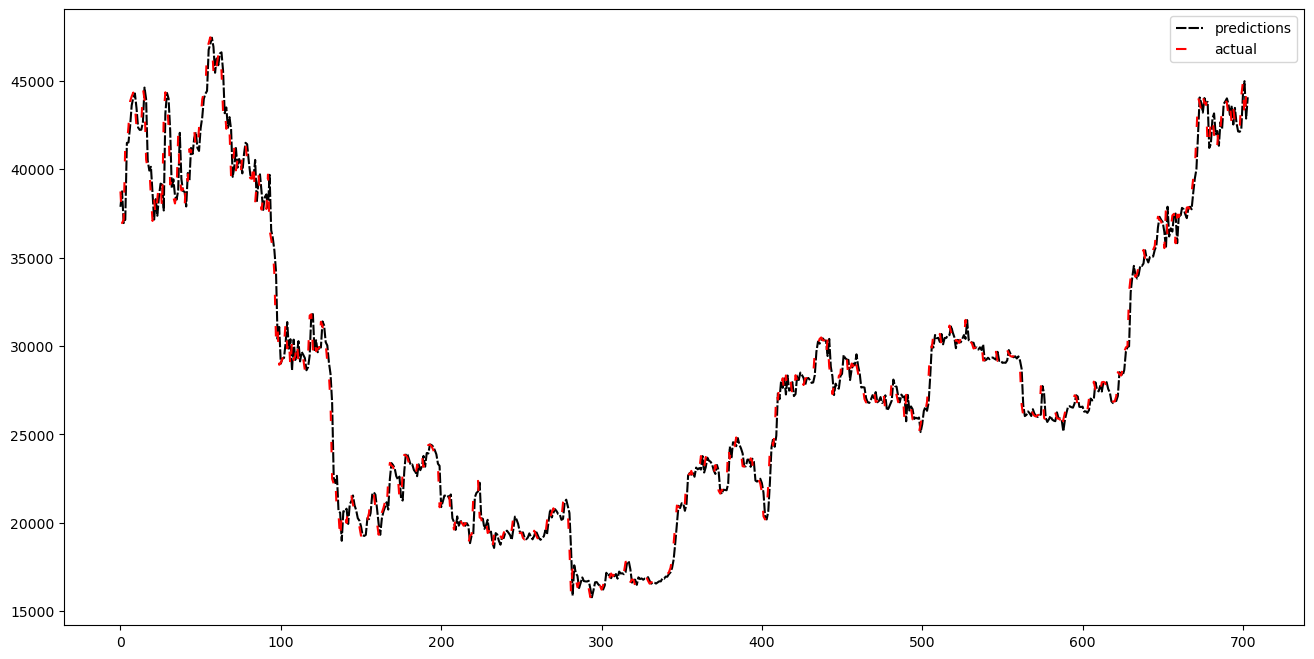

In [41]:
# Plotting the outsamples predictions
plt.figure(figsize = (16,8))
plt.plot(predictions_df['predictions'], label = "predictions",linestyle = (0,(5,1)), color = "black")
plt.plot(outsample_df['close'], label = "actual",linestyle = (0,(5,10)),color ="red")
plt.legend()
plt.show()

### 8.4 Evaluating the Outsample predictions

In [42]:
# Evaluating the Outsample predictions
mse_outsample_test = mean_squared_error(predictions_df,outsample_df)
rmse_outsample_test = sqrt(mse_outsample_test)
r2_outsample_test = r2_score(predictions_df, outsample_df)
mae_outsample_test = mean_absolute_error(predictions_df, outsample_df)
mape_outsample_test = np.mean(np.abs((np.array(predictions_df) - np.array(outsample_df)) / np.array(outsample_df))) * 100

print(f'Mean Squared Error (MSE) for Test Data: {mse_outsample_test:.3f}')
print(f'Root Mean Squared Error (RMSE) for Test Data: {rmse_outsample_test:.3f}')
print(f'R-squared (R^2) Score for Test Data: {r2_outsample_test:.3f}')
print(f'Mean Absolute Error (MAE) for Test Data: {mae_outsample_test:.3f}')
print(f'Mean Absolute Percentage Error (MAPE) for Test Data: {mape_outsample_test:.3f}%')

Mean Squared Error (MSE) for Test Data: 716180.431
Root Mean Squared Error (RMSE) for Test Data: 846.274
R-squared (R^2) Score for Test Data: 0.989
Mean Absolute Error (MAE) for Test Data: 540.840
Mean Absolute Percentage Error (MAPE) for Test Data: 1.901%


In [43]:
out_sample_returns = out_sample_test_2023['Close'].pct_change()
returns = pd.DataFrame(np.array(out_sample_returns),columns = ['actual'])
returns

,actual
0,NaN
1,-0.046209
2,0.005456
3,0.116978
4,-0.001439
...,...
699,0.045005
700,0.017901
701,-0.046928
702,0.031081


In [44]:
predictions_df['return'] = predictions_df['predictions'].pct_change()
predictions_df

,predictions,return
0,37873.965061,NaN
1,38750.948023,0.023155
2,36954.800742,-0.046351
3,37149.265399,0.005262
4,41490.783805,0.116867
...,...,...
699,42285.462631,0.003988
700,44202.317457,0.045331
701,44983.650386,0.017676
702,42867.487560,-0.047043


In [45]:
return_df = pd.DataFrame(np.array(out_sample_returns),columns = ['actual'])
return_df['prediction'] = predictions_df['return']
return_df

,actual,prediction
0,NaN,NaN
1,-0.046209,0.023155
2,0.005456,-0.046351
3,0.116978,0.005262
4,-0.001439,0.116867
...,...,...
699,0.045005,0.003988
700,0.017901,0.045331
701,-0.046928,0.017676
702,0.031081,-0.047043


In [46]:
return_df['actual_close'] = out_sample_test_2023['Close']
return_df['prediction_close'] = predictions_df['predictions']
return_df.head(10)

,actual,prediction,actual_close,prediction_close
0,NaN,NaN,38743.273438,37873.965061
1,-0.046209,0.023155,36952.984375,38750.948023
2,0.005456,-0.046351,37154.601563,36954.800742
3,0.116978,0.005262,41500.875000,37149.265399
4,-0.001439,0.116867,41441.164063,41490.783805
5,0.023437,0.000604,42412.433594,41515.827269
6,0.033666,0.021547,43840.285156,42410.365298
7,0.006345,0.028413,44118.445313,43615.392080
8,0.004995,0.009954,44338.796875,44049.544676
9,-0.017449,0.005432,43565.113281,44288.829141


In [47]:
return_df['actual_return'] = return_df['actual'].cumsum()
return_df['strat_return'] = return_df['prediction'].cumsum()
return_df

,actual,prediction,actual_close,prediction_close,actual_return,strat_return
0,NaN,NaN,38743.273438,37873.965061,NaN,NaN
1,-0.046209,0.023155,36952.984375,38750.948023,-0.046209,0.023155
2,0.005456,-0.046351,37154.601563,36954.800742,-0.040753,-0.023196
3,0.116978,0.005262,41500.875000,37149.265399,0.076225,-0.017934
4,-0.001439,0.116867,41441.164063,41490.783805,0.074786,0.098933
...,...,...,...,...,...,...
699,0.045005,0.003988,44167.332031,42285.462631,0.420326,0.400443
700,0.017901,0.045331,44957.968750,44202.317457,0.438227,0.445774
701,-0.046928,0.017676,42848.175781,44983.650386,0.391299,0.463451
702,0.031081,-0.047043,44179.921875,42867.487560,0.422379,0.416408


### 8.5 Plotting the Actual Return VS Predicted Return

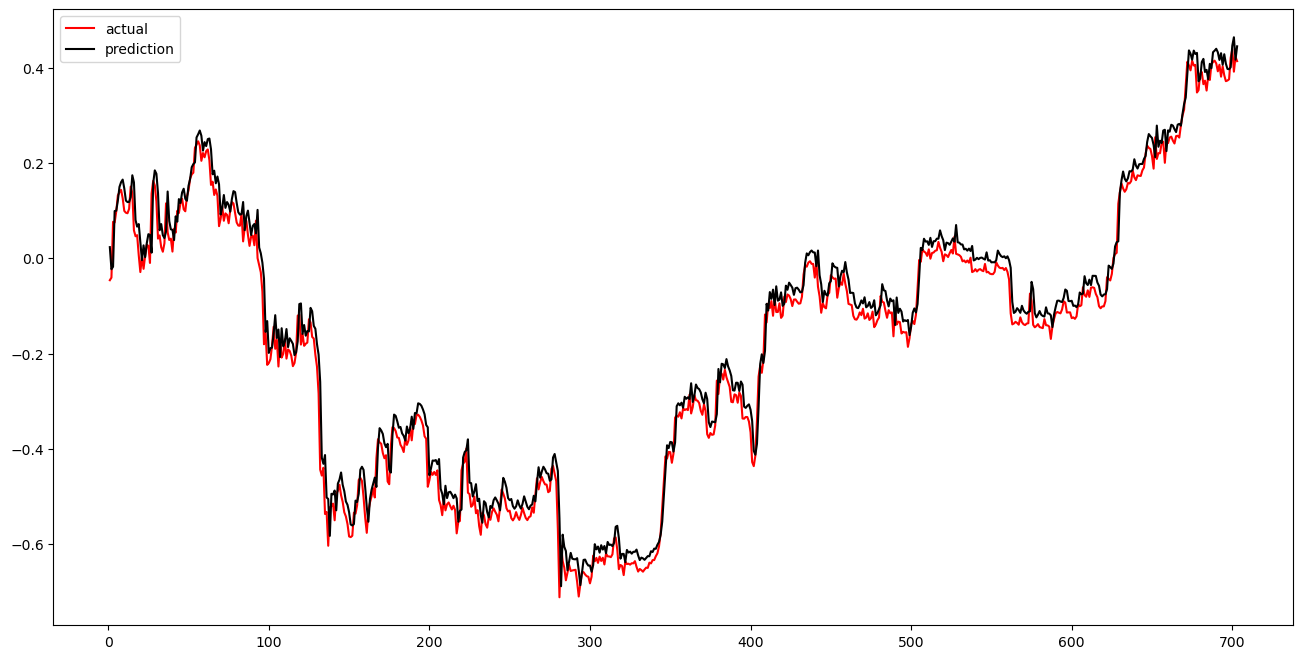

In [48]:
# Plotting the Actual Return VS Predicted Return
plt.figure(figsize = (16,8))
plt.plot(return_df['actual_return'] , label = 'actual', color = 'red')
plt.plot(return_df['strat_return'], label = 'prediction', color = 'black')
plt.legend()
plt.show()

In [49]:
prediction_close = return_df['prediction_close']
actual_close = return_df['actual_close']

## 9. Trading Algorithm

            

### 9.1 Trading Strategy

A simplified description of the trading strategy:

1. **Initialization:**
   - Start with a total investment of $100,000.
   - Set the threshold for allowed predicted drawdown to -0.06.
   - Look 50 steps into the future for predictions.

2. **Trade Execution:**
   - For each step in the prediction data:
     - **Buy Condition:**
        - If there is no current investment:
           - Initiate a buy order.
           - Record the start date of the trade.
     - **Sell Condition:**
        - If the predicted future value decreases beyond the threshold and there is an existing investment:
           - Execute a sell order.
           - Record the profit or loss from the trade.
           - Update the trade duration if applicable.

3. **Trade Tracking:**
   - Keep track of winning and losing trades separately.
   - Record daily returns and adjust the current money based on trade actions.
   - Record trade duration and track the maximum trade duration.

4. **Trade Outcome:**
   - Calculate net earnings based on the final state of the investment.
   - Consider incomplete trades at the end of the prediction data.

5. **Outcome Analysis:**
   - Store winning and losing trades separately.
   - Maintain counts for winning and losing trades.
   - Record trade durations and identify the maximum trade duration.

6. **Earning Statistics:**
   - Calculate various statistics such as net earnings, winning trade count, losing trade count, and maximum trade duration.

In [50]:
# Trading Algorithm

threshold = -0.055 #This is the threshold ( drawdown allowed ) value
steps = 50 # steps the model will look into the future
net_earning = 0
total_investment = 100000  # USD 100,000
current_money = total_investment
current_investment = 0
bitcoin_count = 0
max_trade_duration = 0

winning_trade = [] #Storing all winning trades
loosing_trade = [] #Storing all loosing trades
returns = []  # To store daily returns
previous_investment = current_money #Storing previous investments
loosing_trade_count = 0
winning_trade_count = 0
earning = []
total_closed_trades = 0
holding_duration = []

for i in range(0, len(return_df) - steps):
    future = prediction_close[i + steps]
    current = actual_close[i]
    change = (future - current) / current

    returns.append(change)

    if change < threshold and current_investment != 0:
        # Sell
        current_money = bitcoin_count * current
        current_investment = 0
        earning.append(current_money)

        profit = current_money - previous_investment
        total_closed_trades += 1
        if(profit < 0):
            loosing_trade.append(profit)
            loosing_trade_count += 1
        else:
            winning_trade.append(profit)
            winning_trade_count += 1


        # Update the trade duration
        if trade_start_date is not None:
            current_trade_duration = i - trade_start_date
            holding_duration.append(current_trade_duration)
            max_trade_duration = max(max_trade_duration, current_trade_duration)
            trade_start_date = None

    elif current_investment == 0:
        # Buy
        current_investment = current_money
        bitcoin_count = current_investment / current
        # Record trade start date
        trade_start_date = i

    else:
        continue

if current_investment == 0:
    net_earning = current_money
else:
    net_earning = current_investment

# Handling edge case if the current trade is not finished yet
if current_investment == 0 and trade_start_date is not None:
    current_trade_duration = len(prediction_close) - trade_start_date
    max_trade_duration = max(max_trade_duration, current_trade_duration)

### 9.2 Plotting the Investments made by the model

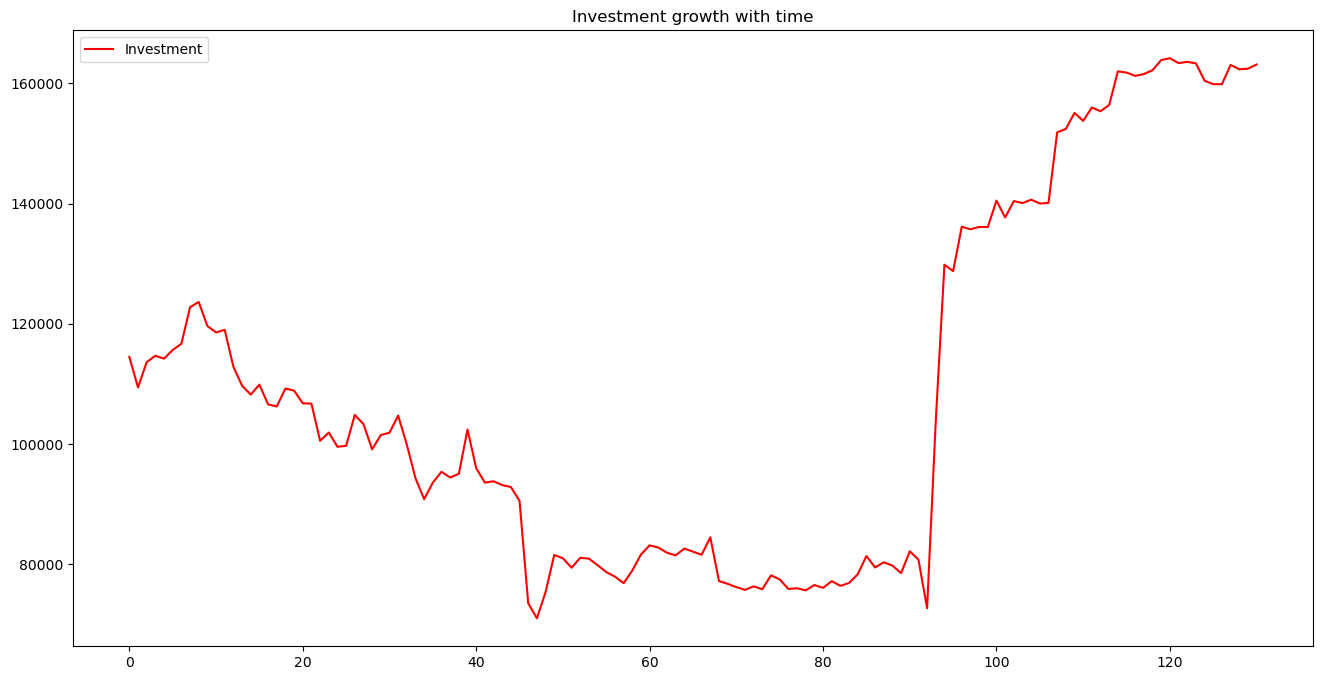

In [51]:
# Plotting the Investments made by the model
plt.figure(figsize=(16,8))
plt.plot(earning,color = "red",label = "Investment")
plt.title("Investment growth with time")
plt.legend()
plt.show()

### 9.3 Trading Benchamrks

In [52]:
# Trading Benchmarks
# Max Drawdown
risk_free_rate = 0.02
daily_returns = predictions_df['predictions'].pct_change()
cumulative_returns = (1 + daily_returns).cumprod()
cumulative_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - cumulative_max) / cumulative_max
max_drawdown = min(drawdown[1:]) * 100

# Profits
strategy_return = net_earning - total_investment

# Calculate Sharpe Ratio
average_return = np.mean(returns) * 252 # Assuming 252 trading days in a year
volatility = np.std(returns) * np.sqrt(252)  # Annualized volatility
sharpe_ratio = (average_return - risk_free_rate) / volatility

print(f"Net Earning : ${net_earning:.3f}")
print(f"Stratergy return : ${strategy_return:.3f}")
print(f"Max Trade Duration : {max_trade_duration} days")
print(f"Sharpe Ratio : {sharpe_ratio:.3f}")
print(f"Maximum Drawdown : {max_drawdown:.3f} %")

#buy and hold return = (Final price - intial price) * BTC_count
initial_price = actual_close[0]
BTC_count = total_investment / initial_price
final_price = actual_close[len(actual_close) - 1]
bhr_return = (final_price - initial_price) * BTC_count
bhr_earning = final_price * BTC_count
print(f'Total benchmark return : {bhr_earning:.3f}')
print(f'Buy and hold return : {bhr_return:.3f}')

# percent increase in net profit generated by using the model strategy
# percent_increase = ( (net_earning - benchmark_earning)/benchmark_earning ) * 100
profit_increase = (net_earning- bhr_earning) / bhr_earning
percent_profit_increase = profit_increase * 100
print(f'Net Profit Exceeding Benchmark Return of the Model : {percent_profit_increase:.3f} %')

# calculating risk-to-reward ratio

#calculating average loosing trade
total_loosing_trade = sum(loosing_trade)
average_loosing_trade = total_loosing_trade / loosing_trade_count
#calculating average winning trade
total_winning_trade = sum(winning_trade)
average_winnning_trade = total_winning_trade / winning_trade_count

risk_to_reward_ratio = average_winnning_trade / abs(average_loosing_trade)
print(f'Risk to reward ratio : {risk_to_reward_ratio:.3f}')

print(f'Average winning trade : {average_winnning_trade:.3f}')
print(f'Average loosing trade : {average_loosing_trade:.3f}')

largest_loosing_trade = min(loosing_trade)
largest_winning_trade = max(winning_trade)
print(f'Largest winning trade : {largest_winning_trade}')
print(f'Largest loosing trade : {largest_loosing_trade}')

print(f'Total closed trades : {total_closed_trades}')
average_holding_duration = np.mean(holding_duration)
print(f'Average holding duration : {average_holding_duration:.0f}')

# Calculating sortino ratio
neg_dev = list(filter(lambda x: (x < 0), returns))
std_dev_neg = np.std(neg_dev)* sqrt(255)
sortino_ratio = (average_return - risk_free_rate) / std_dev_neg
print(f'Sortino ratio : {sortino_ratio:.3f}')

Net Earning : $163112.093
Stratergy return : $63112.093
Max Trade Duration : 72 days
Sharpe Ratio : 1.804
Maximum Drawdown : -66.731 %
Total benchmark return : 113006.219
Buy and hold return : 13006.219
Net Profit Exceeding Benchmark Return of the Model : 44.339 %
Risk to reward ratio : 1.913
Average winning trade : 32839.658
Average loosing trade : -17163.668
Largest winning trade : 64146.76286514019
Largest loosing trade : -28959.77941006978
Total closed trades : 131
Average holding duration : 3
Sortino ratio : 3.407


### 9.4 Plotting of the Drawdowns of the Investment

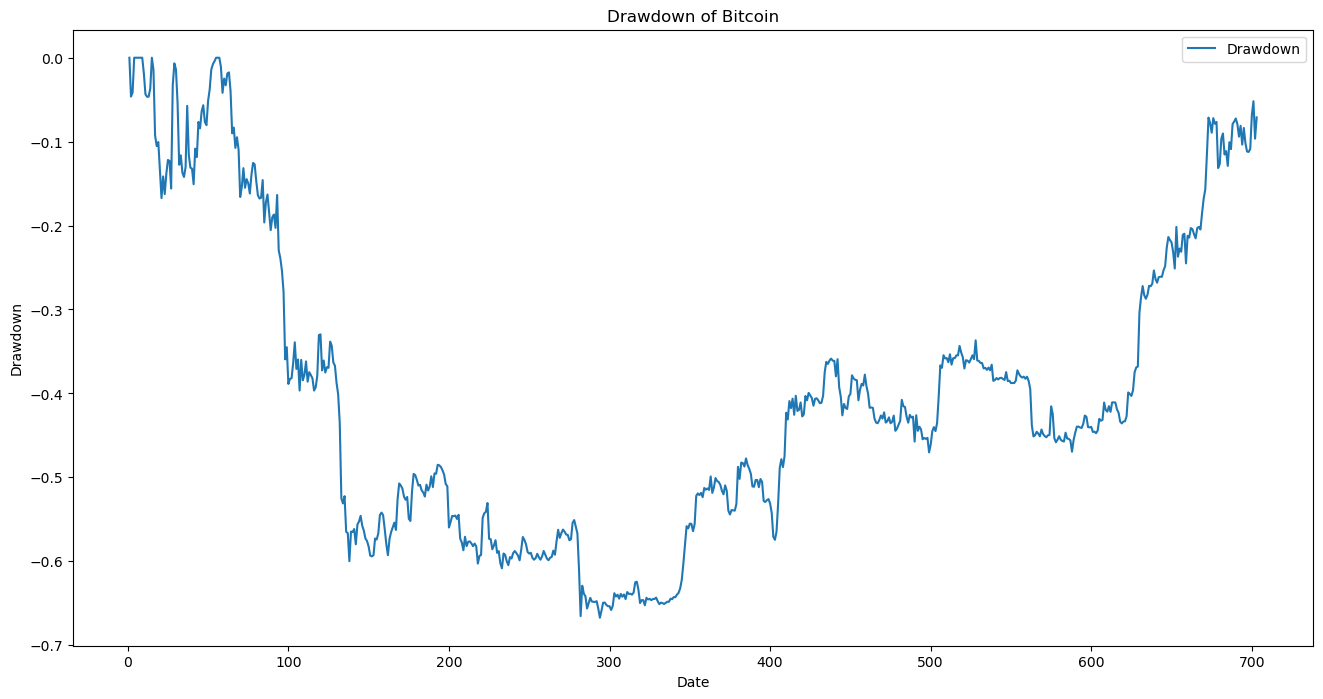

In [53]:
# Plotting of the Drawdowns of the Investment
plt.figure(figsize=(16,8))
drawdown.plot(label='Drawdown')
plt.title('Drawdown of Bitcoin')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()

## Conclusion

Elevated R-squared values and minimal error metrics (RMSE, MAE, MAPE) underscore the ARIMA model's exceptional precision in forecasting Bitcoin prices, showcasing its ability to accurately discern complex patterns. Future endeavors will encompass the exploration of additional features to enhance the model's comprehension and the integration of external datasets for a more comprehensive analysis.

### Made By -
- Soumyadip Moni
- Suvarn Vats
- Krushna Sahoo
- Srizan Saket